# 1. Imports and definiiton

In [1]:
# import the library
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import calendar
import numpy as np
import matplotlib.dates as mdates
import sys
import os
from os import listdir
from os.path import isfile, join
from dateutil import parser
import re
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (GradientBoostingRegressor, 
                              RandomForestRegressor, 
                              AdaBoostRegressor, 
                              BaggingRegressor, 
                              ExtraTreesRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from datetime import datetime, timedelta
from matplotlib import animation
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
# from func_defs import *

%matplotlib ipympl


# define the filename


# define the plot template
axis_label_size = 15
axis_num_size = 12
text_size = 12
title_size = 22

# define the figure size for single plot
figure_size = (6, 6)
subplot_size_1_2 = (6, 6)
long_hoz_figsize = (12, 6)

# 2. Electrical data visualisation

            Timestamp  Power
0 2020-06-01 00:00:00    0.0
1 2020-06-01 00:05:00    0.0
2 2020-06-01 00:10:00    0.0
3 2020-06-01 00:15:00    0.0
4 2020-06-01 00:20:00    0.0


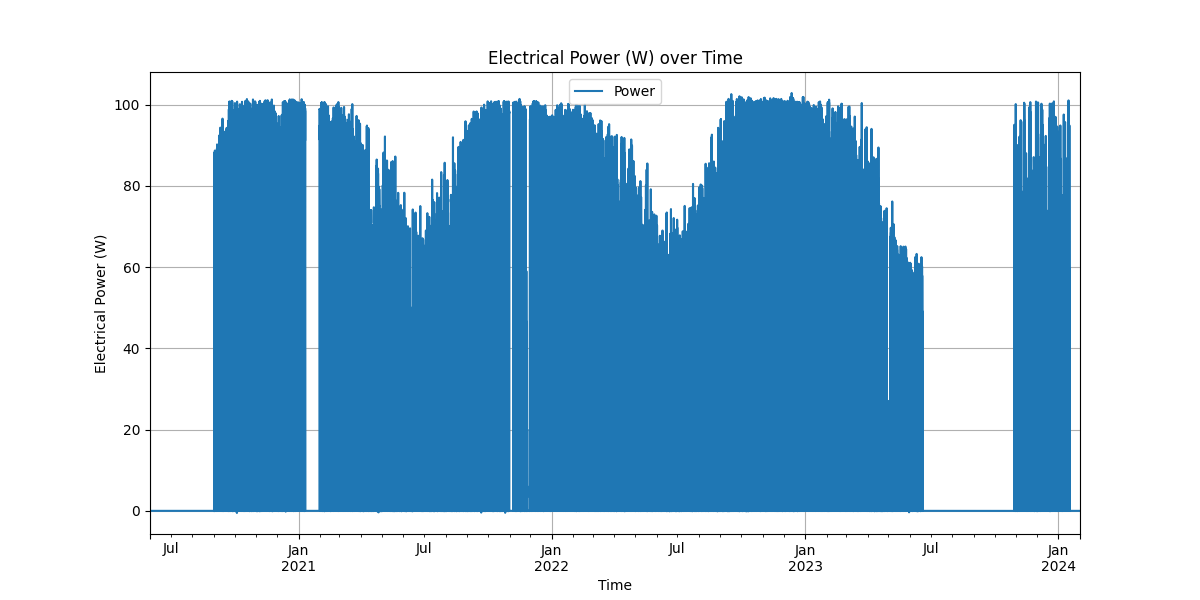

In [2]:
# Load the data from the pickle file
data_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_08_26_Bomen_bifacial_gain\Data\full_site_pow_5min.pkl"
df = pd.read_pickle(data_file)

# print the head
print(df.head())

# downscale to make the power MW
df['Power'] = df['Power']/1e3

# Set the Timestamp as datatime format and index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# plot the data, it only has one column
df.plot(figsize=long_hoz_figsize)
plt.title('Electrical Power (W) over Time')
plt.xlabel('Time')
plt.ylabel('Electrical Power (W)')
plt.grid()
plt.show()


# 3. Simulation results visualisation

## 3.1. Data loading

In [3]:
# simulation results directory
simulation_results_dir = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_09_02_Bomen_bifacial_gain_2021\Data\Bowen Solar Farm 2021_VCG_HourlyRes_1.CSV"

print(f"Loading PVsyst CSV file: {simulation_results_dir}")

try:
    # Load CSV with better parameters
    # Skip rows 0-9 (metadata), use row 10 as header, skip row 11 (units)
    simulation_results_df = pd.read_csv(
        simulation_results_dir,
        delimiter=';',
        skiprows=list(range(10)) + [11],  # Skip metadata (0-9) and units row (11)
        header=0,  # Row 10 becomes the header after skipping
        encoding='latin-1',  # Keep the encoding that worked
        low_memory=False,
        na_values=['', ' ', 'nan', 'NaN']
    )
    
    print(f"Raw DataFrame loaded with shape: {simulation_results_df.shape}")
    
    # Get the first column (should be date/time)
    date_col = simulation_results_df.columns[0]
    print(f"Found date column: '{date_col}'")
    
    # Print sample of raw date values to debug
    print("Sample raw date values:")
    print(simulation_results_df[date_col].head(10).tolist())
    
    # Parse timestamps - Try multiple formats
    # First attempt the specified format
    simulation_results_df['timestamp'] = pd.to_datetime(
        simulation_results_df[date_col], 
        format='%d/%m/%Y %H:%M',  # Try full year format first
        errors='coerce'
    )
    
    # If we have NaT values, try alternative format with 2-digit year
    if simulation_results_df['timestamp'].isna().any():
        print("Some dates failed to parse. Trying alternative format...")
        simulation_results_df['timestamp'] = pd.to_datetime(
            simulation_results_df[date_col], 
            format='%d/%m/%y %H:%M',  # Try 2-digit year format
            errors='coerce'
        )
    
    # If still problems, try the flexible parser
    if simulation_results_df['timestamp'].isna().any():
        print("Still having parsing issues. Using flexible parser...")
        simulation_results_df['timestamp'] = pd.to_datetime(
            simulation_results_df[date_col],
            dayfirst=True,  # Important for DD/MM/YY format
            errors='coerce'
        )
    
    # Drop the original date column
    simulation_results_df = simulation_results_df.drop(columns=[date_col])
    
    # Basic data cleaning
    # Remove rows where timestamp is null
    initial_rows = len(simulation_results_df)
    simulation_results_df = simulation_results_df.dropna(subset=['timestamp'])
    print(f"Removed {initial_rows - len(simulation_results_df)} rows with invalid timestamps")
    
    # Sort by timestamp to ensure chronological order
    simulation_results_df = simulation_results_df.sort_values('timestamp').reset_index(drop=True)
    
    # Remove duplicate timestamps if any
    duplicates = simulation_results_df.duplicated(subset=['timestamp']).sum()
    if duplicates > 0:
        print(f"Found and removing {duplicates} duplicate timestamps")
        simulation_results_df = simulation_results_df.drop_duplicates(subset=['timestamp'], keep='first')
    
    # Data validation and timestamp analysis
    print("\n=== TIMESTAMP ANALYSIS ===")
    print(f"Total timestamps: {len(simulation_results_df)}")
    print(f"Date range: {simulation_results_df['timestamp'].min()} to {simulation_results_df['timestamp'].max()}")
    
    # Check timestamp continuity
    time_diffs = simulation_results_df['timestamp'].diff()[1:]  # Skip first NaT
    common_diff = time_diffs.value_counts().index[0]
    print(f"Most common time difference: {common_diff}")
    
    irregular_intervals = (time_diffs != common_diff).sum()
    if irregular_intervals > 0:
        print(f"Warning: Found {irregular_intervals} irregular time intervals")
    
    # Check distribution of timestamps by month
    month_counts = simulation_results_df['timestamp'].dt.month.value_counts().sort_index()
    print("\nTimestamps per month:")
    for month, count in month_counts.items():
        print(f"Month {month}: {count} timestamps")
    
    # Check the first and last few days of each month
    print("\nDate ranges by month:")
    for month in sorted(simulation_results_df['timestamp'].dt.month.unique()):
        month_data = simulation_results_df[simulation_results_df['timestamp'].dt.month == month]
        print(f"Month {month}: {month_data['timestamp'].min()} to {month_data['timestamp'].max()}")
        # Get unique days in this month
        days = sorted(month_data['timestamp'].dt.day.unique())
        print(f"  Days: {days[:5]}...{days[-5:] if len(days) > 5 else days}")
    
    # Print the columns
    print("\nColumns:")
    print(simulation_results_df.columns.tolist())
    
    # Check for 'EArray' column
    print(f"Does 'EArray' column exist? {'EArray' in simulation_results_df.columns}")
    
except Exception as e:
    print(f"Error loading PVsyst CSV: {e}")
    raise

Loading PVsyst CSV file: C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_09_02_Bomen_bifacial_gain_2021\Data\Bowen Solar Farm 2021_VCG_HourlyRes_1.CSV
Raw DataFrame loaded with shape: (8736, 154)
Found date column: 'date'
Sample raw date values:
['01/01/21 00:00', '01/01/21 01:00', '01/01/21 02:00', '01/01/21 03:00', '01/01/21 04:00', '01/01/21 05:00', '01/01/21 06:00', '01/01/21 07:00', '01/01/21 08:00', '01/01/21 09:00']
Some dates failed to parse. Trying alternative format...
Removed 0 rows with invalid timestamps

=== TIMESTAMP ANALYSIS ===
Total timestamps: 8736
Date range: 2021-01-01 00:00:00 to 2021-12-30 23:00:00
Most common time difference: 0 days 01:00:00

Timestamps per month:
Month 1: 744 timestamps
Month 2: 672 timestamps
Month 3: 744 timestamps
Month 4: 720 timestamps
Month 5: 744 timestamps
Month 6: 720 timestamps
Month 7: 744 timestamps
Month 8: 744 timestamps
Month 9: 720 timestamps
Month 10: 744 timestamps
Month 11: 720 timestamps
Month 12: 720 timestamps

Date 

## 3.2. Visualisation

### 3.2.1. Hourly raw data

EArray column is already numeric type: float64
Set timestamp as index
No clipping applied to EArray values
Resampled actual power from 385920 5-minute intervals to 32160 hourly averages
EArray Min: 0.00 MW
EArray Max: 102.13 MW
EArray Mean: 25.17 MW
Total simulation data points: 8736

Actual Power Min: -0.04 MW
Actual Power Max: 101.03 MW
Actual Power Mean: 19.30 MW
Total actual data points: 32160


C:\Users\z5183876\AppData\Local\Temp\ipykernel_24844\745554493.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_actual_power = df['Power'].resample('H').mean()


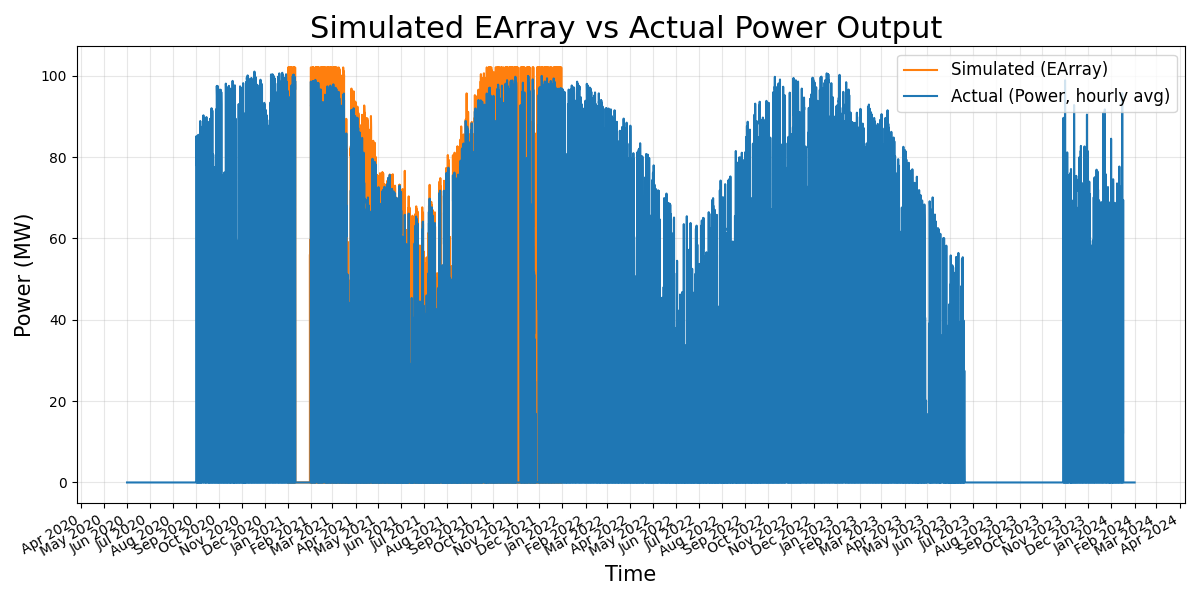

In [4]:
# Define clipping options at the beginning
apply_clipping = False  # Set to False to disable clipping
clipping_threshold = 100  # Clipping threshold in MW

# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Apply clipping to the simulated power if enabled
if apply_clipping:
    simulation_results_df['EArray_display'] = simulation_results_df['EArray'].clip(upper=clipping_threshold)
    print(f"Applied {clipping_threshold} MW clipping to EArray values: {(simulation_results_df['EArray'] > clipping_threshold).sum()} values clipped")
    earray_label = f'Simulated (EArray, clipped at {clipping_threshold} MW)'
else:
    simulation_results_df['EArray_display'] = simulation_results_df['EArray']
    print("No clipping applied to EArray values")
    earray_label = 'Simulated (EArray)'

# Resample the actual power data to hourly averages
hourly_actual_power = df['Power'].resample('H').mean()
print(f"Resampled actual power from {len(df)} 5-minute intervals to {len(hourly_actual_power)} hourly averages")

# Create a figure for both datasets
plt.figure(figsize=long_hoz_figsize)

# Plot simulation EArray data (with or without clipping)
plt.plot(simulation_results_df.index, simulation_results_df['EArray_display'], 
         linewidth=1.5, color='#ff7f0e', label=earray_label)

# Plot actual power data (hourly resampled)
plt.plot(hourly_actual_power.index, hourly_actual_power, 
         linewidth=1.5, color='#1f77b4', label='Actual (Power, hourly avg)')

# Add labels and title
plt.xlabel('Time', fontsize=axis_label_size)
plt.ylabel('Power (MW)', fontsize=axis_label_size)
title_suffix = " (clipped)" if apply_clipping else ""
plt.title(f'Simulated EArray vs Actual Power Output {title_suffix}', fontsize=title_size)

# Add legend
plt.legend(fontsize=text_size)

# Add grid
plt.grid(True, alpha=0.3)

# Format the date on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

# Rotate date labels for better readability
plt.gcf().autofmt_xdate()

# Adjust layout
plt.tight_layout()

# Print some statistics
print(f"EArray Min: {simulation_results_df['EArray_display'].min():.2f} MW")
print(f"EArray Max: {simulation_results_df['EArray_display'].max():.2f} MW")
print(f"EArray Mean: {simulation_results_df['EArray_display'].mean():.2f} MW")
print(f"Total simulation data points: {len(simulation_results_df)}")

print(f"\nActual Power Min: {hourly_actual_power.min():.2f} MW")
print(f"Actual Power Max: {hourly_actual_power.max():.2f} MW")
print(f"Actual Power Mean: {hourly_actual_power.mean():.2f} MW")
print(f"Total actual data points: {len(hourly_actual_power)}")

# Show plot
plt.show()

### 3.2.2. Hourly filtered & scaled

EArray column is already numeric type: float64
Resampled actual power from 385920 5-minute intervals to 32160 hourly averages

=== DATA FILTERING FOR METRICS CALCULATION ===
Step 1: Creating filtered dataframe for metrics
After filtering for matching timestamps: 8736 data points (removed 23424 NaN values)
After filtering for non-zero values: 3856 data points (removed 4880 zero values)

Step 2: Loading and applying maintenance-free days filter
Loaded 233 maintenance-free days
After filtering for maintenance-free days: 2432 data points (removed 1424 points)

Filtered data date range: 2021-01-01 06:00:00 to 2021-12-30 19:00:00
Number of unique days in filtered data: 213

=== SCALING FACTOR OPTIMIZATION ===
Target MBE tolerance: 1.00e-13

Starting binary search for optimal scaling factor...
Initial search range: [0.50000000, 2.00000000]
Iteration 1: Factor = 1.2500000000, MBE = 1.4776442863e+01
Iteration 2: Factor = 0.8750000000, MBE = -3.6548224181e+00
Iteration 3: Factor = 1.0625000000, 

C:\Users\z5183876\AppData\Local\Temp\ipykernel_24844\3098806408.py:24: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_actual_power = df['Power'].resample('H').mean()


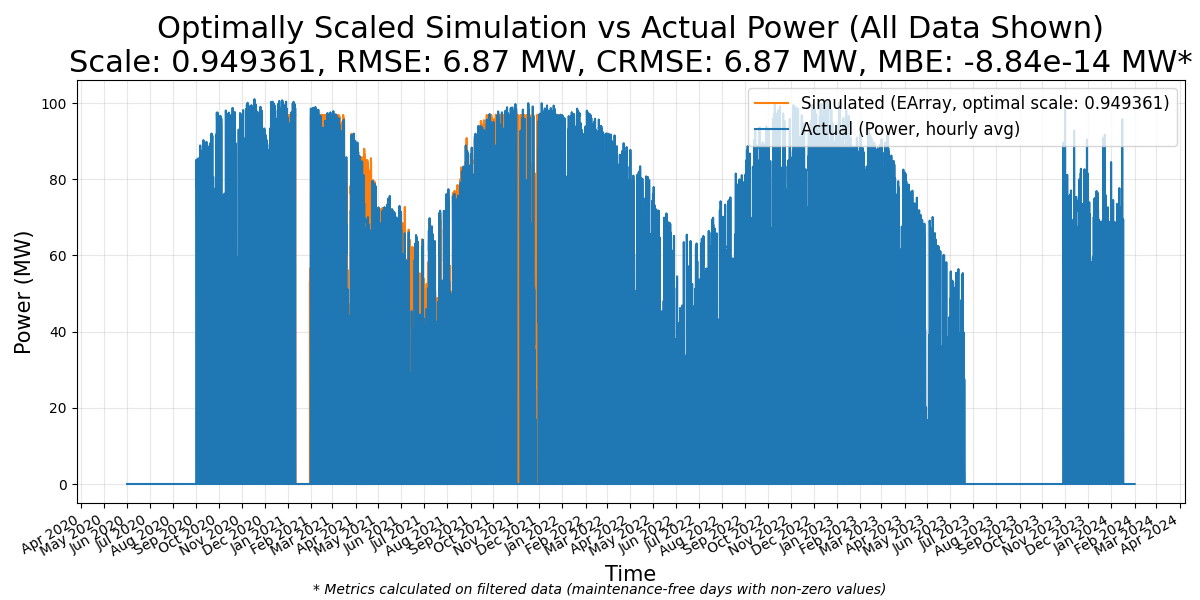


=== STATISTICS WITH OPTIMAL SCALING (FILTERED DATA) ===
Filtered data points: 2432
Scaled EArray Min: 0.54 MW
Scaled EArray Max: 96.95 MW
Scaled EArray Mean: 46.66 MW
Actual Power Min: 0.31 MW
Actual Power Max: 100.29 MW
Actual Power Mean: 46.66 MW

=== STATISTICS WITH OPTIMAL SCALING (ALL DATA) ===
Total simulation data points: 8736
Total actual data points: 32160
Scaled EArray Min: 0.00 MW
Scaled EArray Max: 96.96 MW
Scaled EArray Mean: 23.89 MW
Actual Power Min: -0.04 MW
Actual Power Max: 101.03 MW
Actual Power Mean: 19.30 MW


In [5]:
# Define options at the beginning
apply_clipping = False  # Set to False to disable clipping
clipping_threshold = 100  # Clipping threshold in MW
target_mbe_tolerance = 1e-13  # Target absolute MBE to achieve

# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Resample the actual power data to hourly averages
hourly_actual_power = df['Power'].resample('H').mean()
print(f"Resampled actual power from {len(df)} 5-minute intervals to {len(hourly_actual_power)} hourly averages")

# Create a combined dataframe with both actual and simulated power for metrics calculation
print("\n=== DATA FILTERING FOR METRICS CALCULATION ===")
print("Step 1: Creating filtered dataframe for metrics")
metrics_df = pd.DataFrame()
metrics_df['Actual'] = hourly_actual_power
metrics_df['Simulated'] = simulation_results_df['EArray']

# Filter to include only timestamps where both actual and simulated power exist
initial_rows = len(metrics_df)
metrics_df = metrics_df.dropna()
print(f"After filtering for matching timestamps: {len(metrics_df)} data points (removed {initial_rows - len(metrics_df)} NaN values)")

# Filter to include only timestamps where both actual and simulated power are non-zero
initial_rows = len(metrics_df)
metrics_df = metrics_df[(metrics_df['Actual'] > 0) & (metrics_df['Simulated'] > 0)]
print(f"After filtering for non-zero values: {len(metrics_df)} data points (removed {initial_rows - len(metrics_df)} zero values)")

# Load the maintenance-free days from the text file
print("\nStep 2: Loading and applying maintenance-free days filter")
maintenance_free_days_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_09_02_Bomen_bifacial_gain_2021\Results\remaining_dates_2021.txt"
try:
    with open(maintenance_free_days_file, 'r') as f:
        maintenance_free_days = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"Loaded {len(maintenance_free_days)} maintenance-free days")
    
    # Convert maintenance-free days to datetime for filtering
    maintenance_free_dates = pd.to_datetime(maintenance_free_days)
    
    # Filter the metrics dataframe to only include maintenance-free days
    metrics_df['date'] = metrics_df.index.date
    initial_rows = len(metrics_df)
    metrics_df = metrics_df[metrics_df['date'].isin([date.date() for date in maintenance_free_dates])]
    
    print(f"After filtering for maintenance-free days: {len(metrics_df)} data points (removed {initial_rows - len(metrics_df)} points)")
    
except Exception as e:
    print(f"Error loading maintenance-free days: {e}")
    print("Continuing with only the non-zero, non-NaN data points")

# Print the date range of the filtered data
if len(metrics_df) > 0:
    print(f"\nFiltered data date range: {metrics_df.index.min()} to {metrics_df.index.max()}")
    print(f"Number of unique days in filtered data: {len(metrics_df['date'].unique())}")
else:
    print("\nWarning: No data points remain after filtering!")
    print("Please check your maintenance-free days file and data availability.")

# Check if we have enough data to proceed
if len(metrics_df) < 10:
    print("\nWARNING: Very few data points remain after filtering!")
    print("Results may not be statistically significant.")

# Function to calculate MBE for a given scale factor (uses filtered data)
def calculate_mbe(scale_factor, apply_clip=False, clip_threshold=100):
    """Calculate Mean Bias Error for given scale factor"""
    # Scale the simulated data
    scaled_data = metrics_df['Simulated'] * scale_factor
    
    # Apply clipping if enabled
    if apply_clip:
        scaled_data = scaled_data.clip(upper=clip_threshold)
    
    # Calculate MBE
    return np.mean(scaled_data - metrics_df['Actual'])

print("\n=== SCALING FACTOR OPTIMIZATION ===")
print(f"Target MBE tolerance: {target_mbe_tolerance:.2e}")

# Binary search to find optimal scaling factor
def find_optimal_scaling_factor(min_factor=0.5, max_factor=2.0, max_iterations=100):
    print("\nStarting binary search for optimal scaling factor...")
    print(f"Initial search range: [{min_factor:.8f}, {max_factor:.8f}]")
    
    iterations = 0
    best_factor = None
    best_mbe = float('inf')
    
    while iterations < max_iterations:
        iterations += 1
        mid_factor = (min_factor + max_factor) / 2
        
        # Calculate MBE for the current factor
        mbe = calculate_mbe(mid_factor, apply_clipping, clipping_threshold)
        
        # Track the best factor found
        if abs(mbe) < abs(best_mbe):
            best_factor = mid_factor
            best_mbe = mbe
        
        print(f"Iteration {iterations}: Factor = {mid_factor:.10f}, MBE = {mbe:.10e}")
        
        # Check if we've reached the target precision
        if abs(mbe) < target_mbe_tolerance:
            print(f"✓ Converged! Found factor with MBE below tolerance.")
            return mid_factor, mbe, iterations
        
        # Adjust search range based on MBE sign
        if mbe > 0:  # MBE is positive, need to decrease factor
            max_factor = mid_factor
        else:  # MBE is negative, need to increase factor
            min_factor = mid_factor
        
        # Check if search range is too small (reached numerical precision limit)
        if max_factor - min_factor < 1e-15:
            print(f"! Reached numerical precision limit after {iterations} iterations.")
            print(f"  Best MBE achieved: {best_mbe:.12e}")
            return best_factor, best_mbe, iterations
    
    print(f"! Reached maximum iterations ({max_iterations}).")
    print(f"  Best MBE achieved: {best_mbe:.12e}")
    return best_factor, best_mbe, iterations

# Only proceed with optimization if we have data
if len(metrics_df) > 0:
    # Find the optimal scaling factor using filtered data
    optimal_factor, final_mbe, iterations = find_optimal_scaling_factor()

    print("\n=== OPTIMIZATION RESULTS ===")
    print(f"Optimal scaling factor: {optimal_factor:.10f}")
    print(f"Final MBE: {final_mbe:.12e} MW")
    print(f"Found in {iterations} iterations")

    # Apply the optimal scaling factor to the filtered data for metrics
    PVsyst_scaling = optimal_factor
    print(f"\nApplying optimal scale factor {PVsyst_scaling:.10f} to PVsyst data...")

    # Apply scale factor to filtered data
    metrics_df['Simulated_scaled'] = metrics_df['Simulated'] * PVsyst_scaling

    # Apply clipping to the scaled simulated power if enabled
    if apply_clipping:
        metrics_df['Simulated_display'] = metrics_df['Simulated_scaled'].clip(upper=clipping_threshold)
    else:
        metrics_df['Simulated_display'] = metrics_df['Simulated_scaled']

    # Calculate error metrics with optimal scaling (using filtered data)
    # 1. RMSE (Root Mean Square Error)
    rmse = np.sqrt(mean_squared_error(metrics_df['Actual'], metrics_df['Simulated_display']))
    
    # 2. CRMSE (Centralized Root Mean Square Error)
    actual_centered = metrics_df['Actual'] - metrics_df['Actual'].mean()
    simulated_centered = metrics_df['Simulated_display'] - metrics_df['Simulated_display'].mean()
    crmse = np.sqrt(np.mean((actual_centered - simulated_centered)**2))
    
    # 3. MBE (Mean Bias Error) - should be very close to zero
    mbe = np.mean(metrics_df['Simulated_display'] - metrics_df['Actual'])
    
    print("\n=== ERROR METRICS WITH OPTIMAL SCALING (ON FILTERED DATA) ===")
    print(f"RMSE: {rmse:.4f} MW")
    print(f"CRMSE: {crmse:.4f} MW")
    print(f"MBE: {mbe:.12e} MW")  # Using scientific notation for precision
    
    # Verify if target was met
    if abs(mbe) < target_mbe_tolerance:
        print(f"✓ SUCCESS: |MBE| = {abs(mbe):.12e} < {target_mbe_tolerance:.2e}")
    else:
        print(f"! WARNING: |MBE| = {abs(mbe):.12e} > {target_mbe_tolerance:.2e}")
        print("  Target tolerance not achieved exactly due to numerical precision limits.")

    # Create a figure showing optimized results for ALL data (not just filtered)
    plt.figure(figsize=long_hoz_figsize)

    # Apply the same scaling factor to all simulation data for plotting
    simulation_results_df['EArray_scaled'] = simulation_results_df['EArray'] * PVsyst_scaling
    
    # Apply clipping if enabled
    if apply_clipping:
        simulation_results_df['EArray_display'] = simulation_results_df['EArray_scaled'].clip(upper=clipping_threshold)
        earray_label = f'Simulated (EArray, optimal scale: {PVsyst_scaling:.6f}, clipped)'
    else:
        simulation_results_df['EArray_display'] = simulation_results_df['EArray_scaled']
        earray_label = f'Simulated (EArray, optimal scale: {PVsyst_scaling:.6f})'

    # Plot ALL scaled simulation data (not just filtered)
    plt.plot(simulation_results_df.index, simulation_results_df['EArray_display'], 
             linewidth=1.5, color='#ff7f0e', label=earray_label)

    # Plot ALL actual power data (not just filtered)
    plt.plot(hourly_actual_power.index, hourly_actual_power, 
             linewidth=1.5, color='#1f77b4', label='Actual (Power, hourly avg)')

    # Add labels and title
    plt.xlabel('Time', fontsize=axis_label_size)
    plt.ylabel('Power (MW)', fontsize=axis_label_size)

    # Add metrics to title (but note these are from filtered data)
    plt.title(f'Optimally Scaled Simulation vs Actual Power (All Data Shown)\n'
              f'Scale: {optimal_factor:.6f}, RMSE: {rmse:.2f} MW, CRMSE: {crmse:.2f} MW, MBE: {mbe:.2e} MW*', 
              fontsize=title_size)
    
    # Add a note about metrics
    plt.figtext(0.5, 0.01, 
                '* Metrics calculated on filtered data (maintenance-free days with non-zero values)',
                ha='center', fontsize=10, style='italic')

    # Add legend and formatting
    plt.legend(fontsize=text_size)
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print statistics with optimal scaling for filtered data
    print(f"\n=== STATISTICS WITH OPTIMAL SCALING (FILTERED DATA) ===")
    print(f"Filtered data points: {len(metrics_df)}")
    print(f"Scaled EArray Min: {metrics_df['Simulated_display'].min():.2f} MW")
    print(f"Scaled EArray Max: {metrics_df['Simulated_display'].max():.2f} MW")
    print(f"Scaled EArray Mean: {metrics_df['Simulated_display'].mean():.2f} MW")
    print(f"Actual Power Min: {metrics_df['Actual'].min():.2f} MW")
    print(f"Actual Power Max: {metrics_df['Actual'].max():.2f} MW")
    print(f"Actual Power Mean: {metrics_df['Actual'].mean():.2f} MW")
    
    # Print statistics for all data
    print(f"\n=== STATISTICS WITH OPTIMAL SCALING (ALL DATA) ===")
    print(f"Total simulation data points: {len(simulation_results_df)}")
    print(f"Total actual data points: {len(hourly_actual_power)}")
    print(f"Scaled EArray Min: {simulation_results_df['EArray_display'].min():.2f} MW")
    print(f"Scaled EArray Max: {simulation_results_df['EArray_display'].max():.2f} MW")
    print(f"Scaled EArray Mean: {simulation_results_df['EArray_display'].mean():.2f} MW")
    print(f"Actual Power Min: {hourly_actual_power.min():.2f} MW")
    print(f"Actual Power Max: {hourly_actual_power.max():.2f} MW")
    print(f"Actual Power Mean: {hourly_actual_power.mean():.2f} MW")
else:
    print("\nERROR: No data points remain after filtering. Cannot proceed with optimization.")
    print("Please check your maintenance-free days file and data availability.")

### 3.2.3. Daily filtered & scaled

EArray column is already numeric type: float64
Resampled actual power from 385920 5-minute intervals to 1340 daily totals
Resampled simulated power from 8736 hourly values to 364 daily totals

=== DATA FILTERING FOR METRICS CALCULATION ===
Step 1: Creating filtered dataframe for metrics
After filtering for matching dates: 364 data points (removed 976 NaN values)
After filtering for non-zero values: 329 data points (removed 35 zero values)

Step 2: Loading and applying maintenance-free days filter
Loaded 233 maintenance-free days
After filtering for maintenance-free days: 213 data points (removed 116 points)

Filtered data date range: 2021-01-01 00:00:00 to 2021-12-30 00:00:00
Number of unique days in filtered data: 213

=== SCALING FACTOR OPTIMIZATION ===
Target MBE tolerance: 1.00e-13

Starting binary search for optimal scaling factor...
Initial search range: [0.50000000, 2.00000000]
Iteration 1: Factor = 1.2500000000, MBE = 1.6837286346e+02
Iteration 2: Factor = 0.8750000000, MBE = -

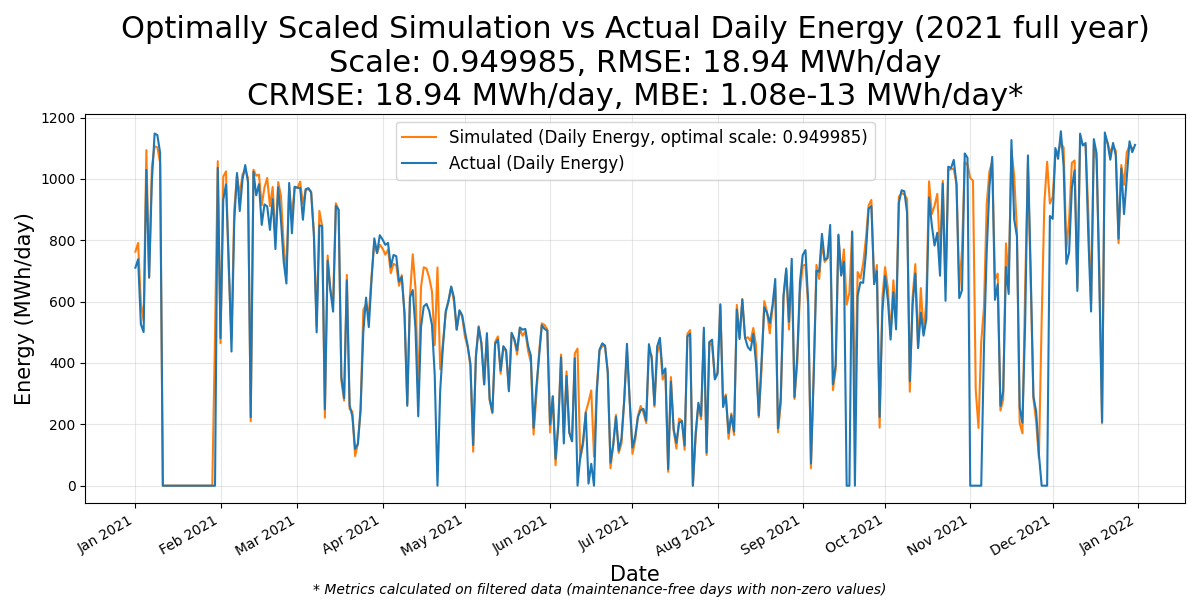


=== STATISTICS WITH OPTIMAL SCALING (2021 DATA) ===
2021 simulation data points: 364
2021 actual data points: 365
Scaled Daily Energy Min: 0.00 MWh/day
Scaled Daily Energy Max: 1119.67 MWh/day
Scaled Daily Energy Mean: 573.82 MWh/day
Actual Daily Energy Min: 0.00 MWh/day
Actual Daily Energy Max: 1155.17 MWh/day
Actual Daily Energy Mean: 539.06 MWh/day


In [6]:
# Define options at the beginning
apply_clipping = False  # Set to False to disable clipping
clipping_threshold = 2400  # Clipping threshold in MWh/day (100 MW × 24 hours)
target_mbe_tolerance = 1e-13  # Target absolute MBE to achieve

# First check if EArray needs conversion (avoid error if already numeric)
if pd.api.types.is_object_dtype(simulation_results_df['EArray']):
    # Only convert if it's still a string/object type
    simulation_results_df['EArray'] = pd.to_numeric(
        simulation_results_df['EArray'].str.replace(',', '.'), 
        errors='coerce'
    )
    print("Converted EArray column from string to numeric")
else:
    print("EArray column is already numeric type:", simulation_results_df['EArray'].dtype)

# Now set the index and sort
if 'timestamp' in simulation_results_df.columns:
    simulation_results_df.set_index('timestamp', inplace=True)
    simulation_results_df.sort_index(inplace=True)
    print("Set timestamp as index")

# Convert Power (MW) to Energy (MWh) for 5-minute data by multiplying by time fraction
df['Energy_MWh'] = df['Power'] * (5/60)  # 5 minutes = 5/60 hours

# Resample actual power data to daily energy totals (MWh/day)
daily_actual_energy = df['Energy_MWh'].resample('D').sum()
print(f"Resampled actual power from {len(df)} 5-minute intervals to {len(daily_actual_energy)} daily totals")

# Convert hourly simulation data (MW) to hourly energy (MWh) and resample to daily
simulation_results_df['EArray_MWh'] = simulation_results_df['EArray'] * 1.0  # 1 hour energy
daily_simulated_energy = simulation_results_df['EArray_MWh'].resample('D').sum()
print(f"Resampled simulated power from {len(simulation_results_df)} hourly values to {len(daily_simulated_energy)} daily totals")

# Create a combined dataframe with both actual and simulated energy for metrics calculation
print("\n=== DATA FILTERING FOR METRICS CALCULATION ===")
print("Step 1: Creating filtered dataframe for metrics")
metrics_df = pd.DataFrame()
metrics_df['Actual'] = daily_actual_energy
metrics_df['Simulated'] = daily_simulated_energy

# Filter to include only timestamps where both actual and simulated energy exist
initial_rows = len(metrics_df)
metrics_df = metrics_df.dropna()
print(f"After filtering for matching dates: {len(metrics_df)} data points (removed {initial_rows - len(metrics_df)} NaN values)")

# Filter to include only timestamps where both actual and simulated energy are non-zero
initial_rows = len(metrics_df)
metrics_df = metrics_df[(metrics_df['Actual'] > 0) & (metrics_df['Simulated'] > 0)]
print(f"After filtering for non-zero values: {len(metrics_df)} data points (removed {initial_rows - len(metrics_df)} zero values)")

# Load the maintenance-free days from the text file
print("\nStep 2: Loading and applying maintenance-free days filter")
# maintenance_free_days_file = r"C:\Users\z5183876\OneDrive - UNSW\Documents\GitHub\25_09_02_Bomen_bifacial_gain_2021\Results\maintenance_free_days_2021.txt"
try:
    with open(maintenance_free_days_file, 'r') as f:
        maintenance_free_days = [line.strip() for line in f.readlines() if line.strip()]
    
    print(f"Loaded {len(maintenance_free_days)} maintenance-free days")
    
    # Convert maintenance-free days to datetime for filtering
    maintenance_free_dates = pd.to_datetime(maintenance_free_days)
    
    # Filter the metrics dataframe to only include maintenance-free days
    metrics_df['date'] = metrics_df.index.date
    initial_rows = len(metrics_df)
    metrics_df = metrics_df[metrics_df['date'].isin([date.date() for date in maintenance_free_dates])]
    
    print(f"After filtering for maintenance-free days: {len(metrics_df)} data points (removed {initial_rows - len(metrics_df)} points)")
    
except Exception as e:
    print(f"Error loading maintenance-free days: {e}")
    print("Continuing with only the non-zero, non-NaN data points")

# Print the date range of the filtered data
if len(metrics_df) > 0:
    print(f"\nFiltered data date range: {metrics_df.index.min()} to {metrics_df.index.max()}")
    print(f"Number of unique days in filtered data: {len(metrics_df['date'].unique())}")
else:
    print("\nWarning: No data points remain after filtering!")
    print("Please check your maintenance-free days file and data availability.")

# Check if we have enough data to proceed
if len(metrics_df) < 10:
    print("\nWARNING: Very few data points remain after filtering!")
    print("Results may not be statistically significant.")

# Function to calculate MBE for a given scale factor (uses filtered data)
def calculate_mbe(scale_factor, apply_clip=False, clip_threshold=2400):
    """Calculate Mean Bias Error for given scale factor"""
    # Scale the simulated data
    scaled_data = metrics_df['Simulated'] * scale_factor
    
    # Apply clipping if enabled
    if apply_clip:
        scaled_data = scaled_data.clip(upper=clip_threshold)
    
    # Calculate MBE
    return np.mean(scaled_data - metrics_df['Actual'])

print("\n=== SCALING FACTOR OPTIMIZATION ===")
print(f"Target MBE tolerance: {target_mbe_tolerance:.2e}")

# Binary search to find optimal scaling factor
def find_optimal_scaling_factor(min_factor=0.5, max_factor=2.0, max_iterations=100):
    print("\nStarting binary search for optimal scaling factor...")
    print(f"Initial search range: [{min_factor:.8f}, {max_factor:.8f}]")
    
    iterations = 0
    best_factor = None
    best_mbe = float('inf')
    
    while iterations < max_iterations:
        iterations += 1
        mid_factor = (min_factor + max_factor) / 2
        
        # Calculate MBE for the current factor
        mbe = calculate_mbe(mid_factor, apply_clipping, clipping_threshold)
        
        # Track the best factor found
        if abs(mbe) < abs(best_mbe):
            best_factor = mid_factor
            best_mbe = mbe
        
        print(f"Iteration {iterations}: Factor = {mid_factor:.10f}, MBE = {mbe:.10e}")
        
        # Check if we've reached the target precision
        if abs(mbe) < target_mbe_tolerance:
            print(f"✓ Converged! Found factor with MBE below tolerance.")
            return mid_factor, mbe, iterations
        
        # Adjust search range based on MBE sign
        if mbe > 0:  # MBE is positive, need to decrease factor
            max_factor = mid_factor
        else:  # MBE is negative, need to increase factor
            min_factor = mid_factor
        
        # Check if search range is too small (reached numerical precision limit)
        if max_factor - min_factor < 1e-15:
            print(f"! Reached numerical precision limit after {iterations} iterations.")
            print(f"  Best MBE achieved: {best_mbe:.12e}")
            return best_factor, best_mbe, iterations
    
    print(f"! Reached maximum iterations ({max_iterations}).")
    print(f"  Best MBE achieved: {best_mbe:.12e}")
    return best_factor, best_mbe, iterations

# Only proceed with optimization if we have data
if len(metrics_df) > 0:
    # Find the optimal scaling factor using filtered data
    optimal_factor, final_mbe, iterations = find_optimal_scaling_factor()

    print("\n=== OPTIMIZATION RESULTS ===")
    print(f"Optimal scaling factor: {optimal_factor:.10f}")
    print(f"Final MBE: {final_mbe:.12e} MWh/day")
    print(f"Found in {iterations} iterations")

    # Apply the optimal scaling factor to the filtered data for metrics
    PVsyst_scaling = optimal_factor
    print(f"\nApplying optimal scale factor {PVsyst_scaling:.10f} to PVsyst data...")

    # Apply scale factor to filtered data
    metrics_df['Simulated_scaled'] = metrics_df['Simulated'] * PVsyst_scaling

    # Apply clipping to the scaled simulated energy if enabled
    if apply_clipping:
        metrics_df['Simulated_display'] = metrics_df['Simulated_scaled'].clip(upper=clipping_threshold)
    else:
        metrics_df['Simulated_display'] = metrics_df['Simulated_scaled']

    # Calculate error metrics with optimal scaling (using filtered data)
    # 1. RMSE (Root Mean Square Error)
    rmse = np.sqrt(mean_squared_error(metrics_df['Actual'], metrics_df['Simulated_display']))
    
    # 2. CRMSE (Centralized Root Mean Square Error)
    actual_centered = metrics_df['Actual'] - metrics_df['Actual'].mean()
    simulated_centered = metrics_df['Simulated_display'] - metrics_df['Simulated_display'].mean()
    crmse = np.sqrt(np.mean((actual_centered - simulated_centered)**2))
    
    # 3. MBE (Mean Bias Error) - should be very close to zero
    mbe = np.mean(metrics_df['Simulated_display'] - metrics_df['Actual'])
    
    print("\n=== ERROR METRICS WITH OPTIMAL SCALING (ON FILTERED DATA) ===")
    print(f"RMSE: {rmse:.4f} MWh/day")
    print(f"CRMSE: {crmse:.4f} MWh/day")
    print(f"MBE: {mbe:.12e} MWh/day")  # Using scientific notation for precision
    
    # Verify if target was met
    if abs(mbe) < target_mbe_tolerance:
        print(f"✓ SUCCESS: |MBE| = {abs(mbe):.12e} < {target_mbe_tolerance:.2e}")
    else:
        print(f"! WARNING: |MBE| = {abs(mbe):.12e} > {target_mbe_tolerance:.2e}")
        print("  Target tolerance not achieved exactly due to numerical precision limits.")

    # Create a figure showing optimized results for 2021 data only
    plt.figure(figsize=long_hoz_figsize)

    # Convert hourly simulation data to daily for plotting (all data)
    all_daily_simulated = simulation_results_df['EArray_MWh'].resample('D').sum()
    
    # Apply the same scaling factor to all simulation data for plotting
    all_daily_simulated_scaled = all_daily_simulated * PVsyst_scaling
    
    # Apply clipping if enabled
    if apply_clipping:
        all_daily_simulated_display = all_daily_simulated_scaled.clip(upper=clipping_threshold)
        earray_label = f'Simulated (Daily Energy, optimal scale: {PVsyst_scaling:.6f}, clipped)'
    else:
        all_daily_simulated_display = all_daily_simulated_scaled
        earray_label = f'Simulated (Daily Energy, optimal scale: {PVsyst_scaling:.6f})'
        
    # FILTER FOR 2021 DATA ONLY
    # Filter simulated and actual data to only include 2021
    year_2021_simulated = all_daily_simulated_display[all_daily_simulated_display.index.year == 2021]
    year_2021_actual = daily_actual_energy[daily_actual_energy.index.year == 2021]
    
    print(f"\n=== 2021 DATA FILTERING ===")
    print(f"Total days in 2021 with simulation data: {len(year_2021_simulated)}")
    print(f"Total days in 2021 with actual data: {len(year_2021_actual)}")

    # Plot 2021 scaled simulation data
    plt.plot(year_2021_simulated.index, year_2021_simulated, 
             linewidth=1.5, color='#ff7f0e', label=earray_label)

    # Plot 2021 actual energy data
    plt.plot(year_2021_actual.index, year_2021_actual, 
             linewidth=1.5, color='#1f77b4', label='Actual (Daily Energy)')

    # Add labels and title
    plt.xlabel('Date', fontsize=axis_label_size)
    plt.ylabel('Energy (MWh/day)', fontsize=axis_label_size)

    # Add metrics to title (but note these are from filtered data)
    plt.title(f'Optimally Scaled Simulation vs Actual Daily Energy (2021 full year)\n'
              f'Scale: {optimal_factor:.6f}, RMSE: {rmse:.2f} MWh/day\n'
              f'CRMSE: {crmse:.2f} MWh/day, MBE: {mbe:.2e} MWh/day*', 
              fontsize=title_size)
    
    # Add a note about metrics
    plt.figtext(0.5, 0.01, 
                '* Metrics calculated on filtered data (maintenance-free days with non-zero values)',
                ha='center', fontsize=10, style='italic')

    # Add legend and formatting
    plt.legend(fontsize=text_size)
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print statistics for 2021 data
    print(f"\n=== STATISTICS WITH OPTIMAL SCALING (2021 DATA) ===")
    print(f"2021 simulation data points: {len(year_2021_simulated)}")
    print(f"2021 actual data points: {len(year_2021_actual)}")
    print(f"Scaled Daily Energy Min: {year_2021_simulated.min():.2f} MWh/day")
    print(f"Scaled Daily Energy Max: {year_2021_simulated.max():.2f} MWh/day")
    print(f"Scaled Daily Energy Mean: {year_2021_simulated.mean():.2f} MWh/day")
    print(f"Actual Daily Energy Min: {year_2021_actual.min():.2f} MWh/day")
    print(f"Actual Daily Energy Max: {year_2021_actual.max():.2f} MWh/day")
    print(f"Actual Daily Energy Mean: {year_2021_actual.mean():.2f} MWh/day")
else:
    print("\nERROR: No data points remain after filtering. Cannot proceed with optimization.")
    print("Please check your maintenance-free days file and data availability.")


=== FILTERED 2021 DATA FOR PLOTTING ===
Total days in filtered 2021 data: 213


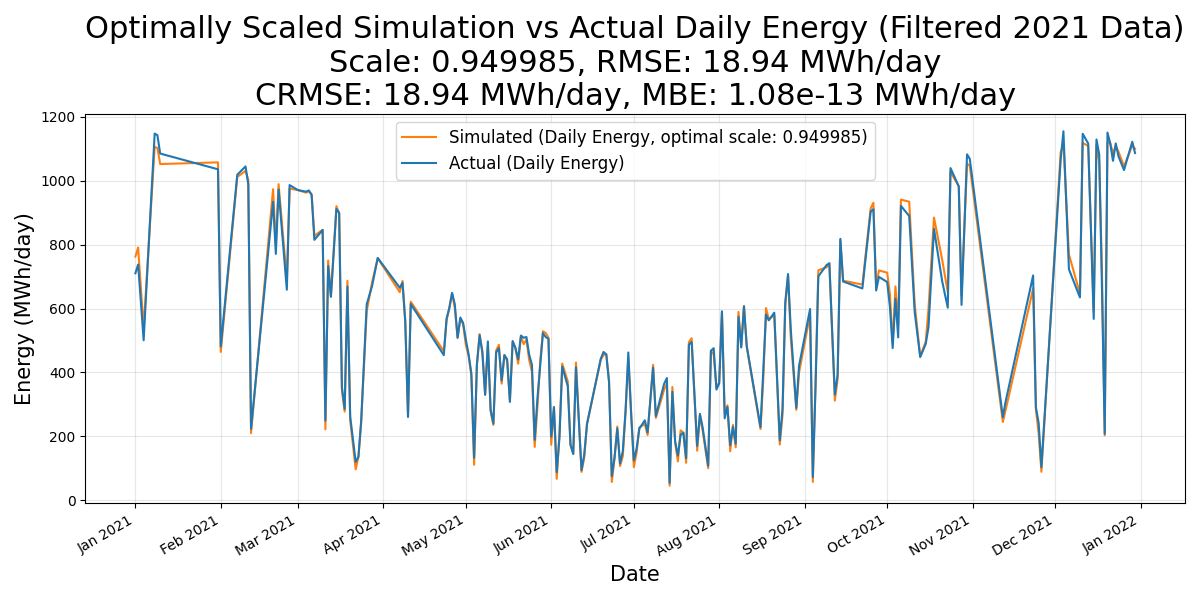


=== STATISTICS WITH OPTIMAL SCALING (FILTERED 2021 DATA) ===
Filtered 2021 data points: 213
Scaled Daily Energy Min: 45.31 MWh/day
Scaled Daily Energy Max: 1119.67 MWh/day
Scaled Daily Energy Mean: 533.15 MWh/day
Actual Daily Energy Min: 53.98 MWh/day
Actual Daily Energy Max: 1155.17 MWh/day
Actual Daily Energy Mean: 533.15 MWh/day


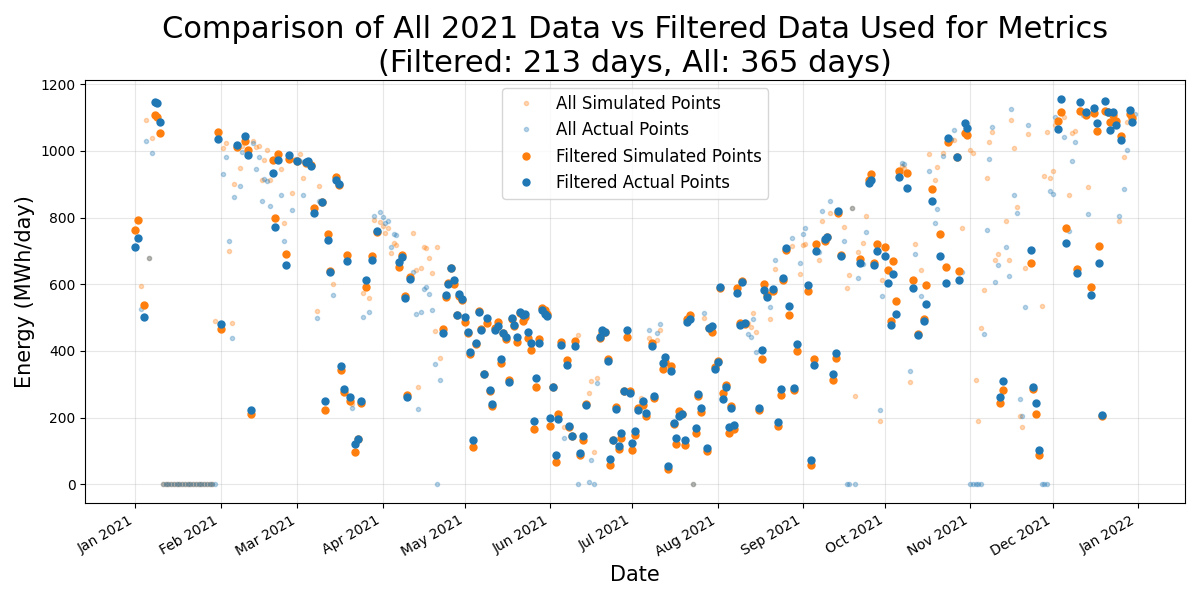

In [7]:
# ...existing code...

# Create a figure showing optimized results for filtered 2021 data only
plt.figure(figsize=long_hoz_figsize)

# Filter metrics_df to only include 2021 data - this ensures we use the same filtered data
# that was used for metrics calculation
filtered_2021_metrics = metrics_df[metrics_df.index.year == 2021].copy()
print(f"\n=== FILTERED 2021 DATA FOR PLOTTING ===")
print(f"Total days in filtered 2021 data: {len(filtered_2021_metrics)}")

if len(filtered_2021_metrics) > 0:
    # Plot only the filtered 2021 data with optimal scaling
    plt.plot(filtered_2021_metrics.index, filtered_2021_metrics['Simulated_display'], 
             linewidth=1.5, color='#ff7f0e', 
             label=f'Simulated (Daily Energy, optimal scale: {PVsyst_scaling:.6f})')

    # Plot the same filtered 2021 actual data
    plt.plot(filtered_2021_metrics.index, filtered_2021_metrics['Actual'], 
             linewidth=1.5, color='#1f77b4', label='Actual (Daily Energy)')

    # Add labels and title
    plt.xlabel('Date', fontsize=axis_label_size)
    plt.ylabel('Energy (MWh/day)', fontsize=axis_label_size)

    # Update title to indicate this is filtered data
    plt.title(f'Optimally Scaled Simulation vs Actual Daily Energy (Filtered 2021 Data)\n'
              f'Scale: {optimal_factor:.6f}, RMSE: {rmse:.2f} MWh/day\n'
              f'CRMSE: {crmse:.2f} MWh/day, MBE: {mbe:.2e} MWh/day', 
              fontsize=title_size)
    
    # No need for the note about metrics since we're showing exactly the filtered data used for metrics

    # Add legend and formatting
    plt.legend(fontsize=text_size)
    plt.grid(True, alpha=0.3)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print statistics for filtered 2021 data
    print(f"\n=== STATISTICS WITH OPTIMAL SCALING (FILTERED 2021 DATA) ===")
    print(f"Filtered 2021 data points: {len(filtered_2021_metrics)}")
    print(f"Scaled Daily Energy Min: {filtered_2021_metrics['Simulated_display'].min():.2f} MWh/day")
    print(f"Scaled Daily Energy Max: {filtered_2021_metrics['Simulated_display'].max():.2f} MWh/day")
    print(f"Scaled Daily Energy Mean: {filtered_2021_metrics['Simulated_display'].mean():.2f} MWh/day")
    print(f"Actual Daily Energy Min: {filtered_2021_metrics['Actual'].min():.2f} MWh/day")
    print(f"Actual Daily Energy Max: {filtered_2021_metrics['Actual'].max():.2f} MWh/day")
    print(f"Actual Daily Energy Mean: {filtered_2021_metrics['Actual'].mean():.2f} MWh/day")
else:
    print("\nERROR: No filtered data points from 2021 remain after filtering.")
    print("Please check your maintenance-free days file and data availability.")

# OPTIONAL: You can also add a second plot to show the comparison between filtered and unfiltered data
plt.figure(figsize=long_hoz_figsize)

# Filter all 2021 data (unfiltered)
year_2021_simulated = all_daily_simulated_display[all_daily_simulated_display.index.year == 2021]
year_2021_actual = daily_actual_energy[daily_actual_energy.index.year == 2021]

# Plot all 2021 data points
plt.plot(year_2021_simulated.index, year_2021_simulated, 'o', markersize=3, alpha=0.3, color='#ff7f0e', label='All Simulated Points')
plt.plot(year_2021_actual.index, year_2021_actual, 'o', markersize=3, alpha=0.3, color='#1f77b4', label='All Actual Points')

# Highlight the filtered points
plt.plot(filtered_2021_metrics.index, filtered_2021_metrics['Simulated_display'], 'o', markersize=5, color='#ff7f0e', label='Filtered Simulated Points')
plt.plot(filtered_2021_metrics.index, filtered_2021_metrics['Actual'], 'o', markersize=5, color='#1f77b4', label='Filtered Actual Points')

plt.xlabel('Date', fontsize=axis_label_size)
plt.ylabel('Energy (MWh/day)', fontsize=axis_label_size)
plt.title(f'Comparison of All 2021 Data vs Filtered Data Used for Metrics\n(Filtered: {len(filtered_2021_metrics)} days, All: {len(year_2021_actual)} days)', 
          fontsize=title_size)
plt.legend(fontsize=text_size)
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# ...existing code...